<a href="https://colab.research.google.com/github/TomBombadil95/SPBD/blob/main/trial11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib e Fun

In [ ]:
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.prune import l1_unstructured
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import argparse

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def load_dataset(name, batch_size):
    m = getattr(datasets, name)
    ds_train = m("./data", train=True, download=True, transform=transforms.ToTensor())
    ds_test = m("./data", train=False, download=True, transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def accuracy(model, test_loader, device):
    tot = 0; correct = 0
    with torch.no_grad():
        for j, (inputs,labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model(inputs)

            _, preds = torch.max(out, dim=1)
            
            tot += len(inputs)
            correct += torch.sum(preds == labels).item()
    print('Correct predictions: ',correct, 'over', tot)
    return correct/tot

def create_penalty_masks(trained_model, orig_model, amount = 0.5):
    star_params = [p.clone().detach() for p in trained_model.parameters()]
    penalty = {}
    masks = {}
    for (name,p), (_,imp), p_star in zip(orig_model.named_parameters(), trained_model.importances, star_params):
            penalty[name] = imp * torch.square(p - p_star)

    for lay,pen in penalty.items():
        name =  tuple(lay.split("."))
        module = getattr(trained_model, name[0])
        l1_unstructured(module, name[1],  amount = amount, importance_scores=pen)

    
    for (n,i) in trained_model.named_buffers():
         masks[n] = 1-i

    return masks

def training(model, orig_model, train_loader, criterion, optim, batch_size, device, masks, k = 10, alfa = 100, exponential_factor=1):
    if orig_model is not None:
      model.load_state_dict(orig_model.state_dict(), strict=False)
    model.reset()
    
    accumulators = [torch.zeros_like(p, device=device) for p in model.parameters()]
    losses = []

    for i, (inputs, labels) in enumerate(train_loader):
        if k > 0 and i == k:
            break
        
        inputs = inputs.to(device); labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        if masks is not None:
            tot_importance = 0
            for p,(_,mask),(_,imp), p_star in zip(model.parameters(), masks.items(), model.importances, orig_model.parameters()):
                mean = torch.sum(mask * imp * torch.square(p - p_star))
                tot_importance += mean

            tot_importance = (alfa * np.exp(-exponential_factor * i))*tot_importance

            loss += tot_importance

        optim.zero_grad()
        loss.backward()
        optim.step()
                
        for accum, v in zip(accumulators, model.parameters()):
            accum.add_(v.grad.square())

    for accum, (_,imp) in zip(accumulators, model.importances): 
        imp.add_(accum / len(train_loader))  

    return losses


def loss_plot(x, k, n):
  offset = 0
  start = 0

  for t in range(n):
    v = x[t]    
  # for t, v in x.items():
    plt.plot(list(range(start, start + len(v))), v)
    start = start + len(v)
  
  t = n
  v = x[t]
  plt.plot(list(range(start, start + len(v))), v)


def acc_plot(x):
  plt.plot(x)
  plt.ylim(0,1)

# Experiment

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3)   #CIFAR10 --> (3,64,3)   #MNIST ---> (1,64,3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(4608, 128)   #with conv--> 3200   #without conv --> 784    ; #CIFAR10 --> (4608, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.importances = [(k, torch.zeros_like(p, device=device))  for k, p in self.named_parameters()]

    def forward(self, x):
        x =  F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def reset(self):
        # reinitialize network
        # for layer in self.children():
        #     layer.reset_parameters()
        # clear importance
        for _,imp in self.importances:
            imp.fill_(0.)

In [ ]:
LR = 0.001
BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
K = 20
N = 10
AMOUNT = 0.1
dataset = 'CIFAR10'
alfa = 100

In [ ]:
train, test = load_dataset(dataset, BATCH_SIZE) 

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = SimpleModel().to(device)
copy_mod = deepcopy(model)

los = {}; masks = None
acc = {}

for n in range(N):
    optim= torch.optim.Adam(model.parameters(), lr=LR)

    los[n] = training(model, copy_mod, train, criterion, optim, batch_size = BATCH_SIZE, device = device, k = K, masks =  masks, 
                      alfa = alfa, exponential_factor=0.1)
    masks = create_penalty_masks(model, copy_mod, amount = AMOUNT)
    a = accuracy(model, test, device)
    acc[n] = a

optim= torch.optim.Adam(model.parameters(), lr=LR)
M = len(train) - K*N        
los[N] = training(model, copy_mod, train, criterion, optim, batch_size = BATCH_SIZE, device = device, k = -1, masks = masks, 
                  alfa = alfa, exponential_factor=0.1)
print('\n\n\n\n\n')
a = accuracy(model, test, device)
acc[N] = a

Correct predictions:  1747 over 10000
Correct predictions:  2040 over 10000
Correct predictions:  2476 over 10000
Correct predictions:  2399 over 10000
Correct predictions:  2948 over 10000
Correct predictions:  3109 over 10000
Correct predictions:  2545 over 10000
Correct predictions:  2366 over 10000
Correct predictions:  2733 over 10000
Correct predictions:  2947 over 10000






Correct predictions:  5511 over 10000


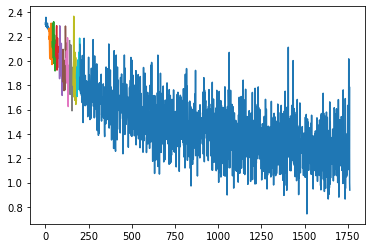

In [ ]:
loss_plot(los, K, N)

In [ ]:
train, test = load_dataset(dataset, BATCH_SIZE)
optim= torch.optim.Adam(model.parameters(), lr=LR)
loss_single_epoch = training(model, copy_mod, train, criterion, optim, batch_size = BATCH_SIZE, device = device, k = -1, masks =  None)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
accuracy(model, test, device)

Correct predictions:  6436 over 10000


0.6436

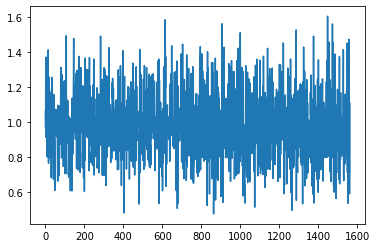

In [ ]:
plt.plot(range(len(loss_single_epoch)), loss_single_epoch)